# 10 - Atmospheric Pressure Analysis

This notebook analyzes the relationship between atmospheric pressure and earthquake occurrence.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '10_pressure')
os.makedirs(OUTPUT_DIR, exist_ok=True)

eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

eq_pressure = eq_df[eq_df['pressure_hpa'].notna()].copy()
print(f"Records with pressure data: {len(eq_pressure):,}")

Records with pressure data: 524,952


In [2]:
# Pressure statistics
print("\nAtmospheric Pressure Statistics:")
print(f"  Mean: {eq_pressure['pressure_hpa'].mean():.1f} hPa")
print(f"  Std: {eq_pressure['pressure_hpa'].std():.1f} hPa")
print(f"  Range: {eq_pressure['pressure_hpa'].min():.1f} - {eq_pressure['pressure_hpa'].max():.1f} hPa")


Atmospheric Pressure Statistics:
  Mean: 900.9 hPa
  Std: 7.9 hPa
  Range: 880.0 - 935.9 hPa


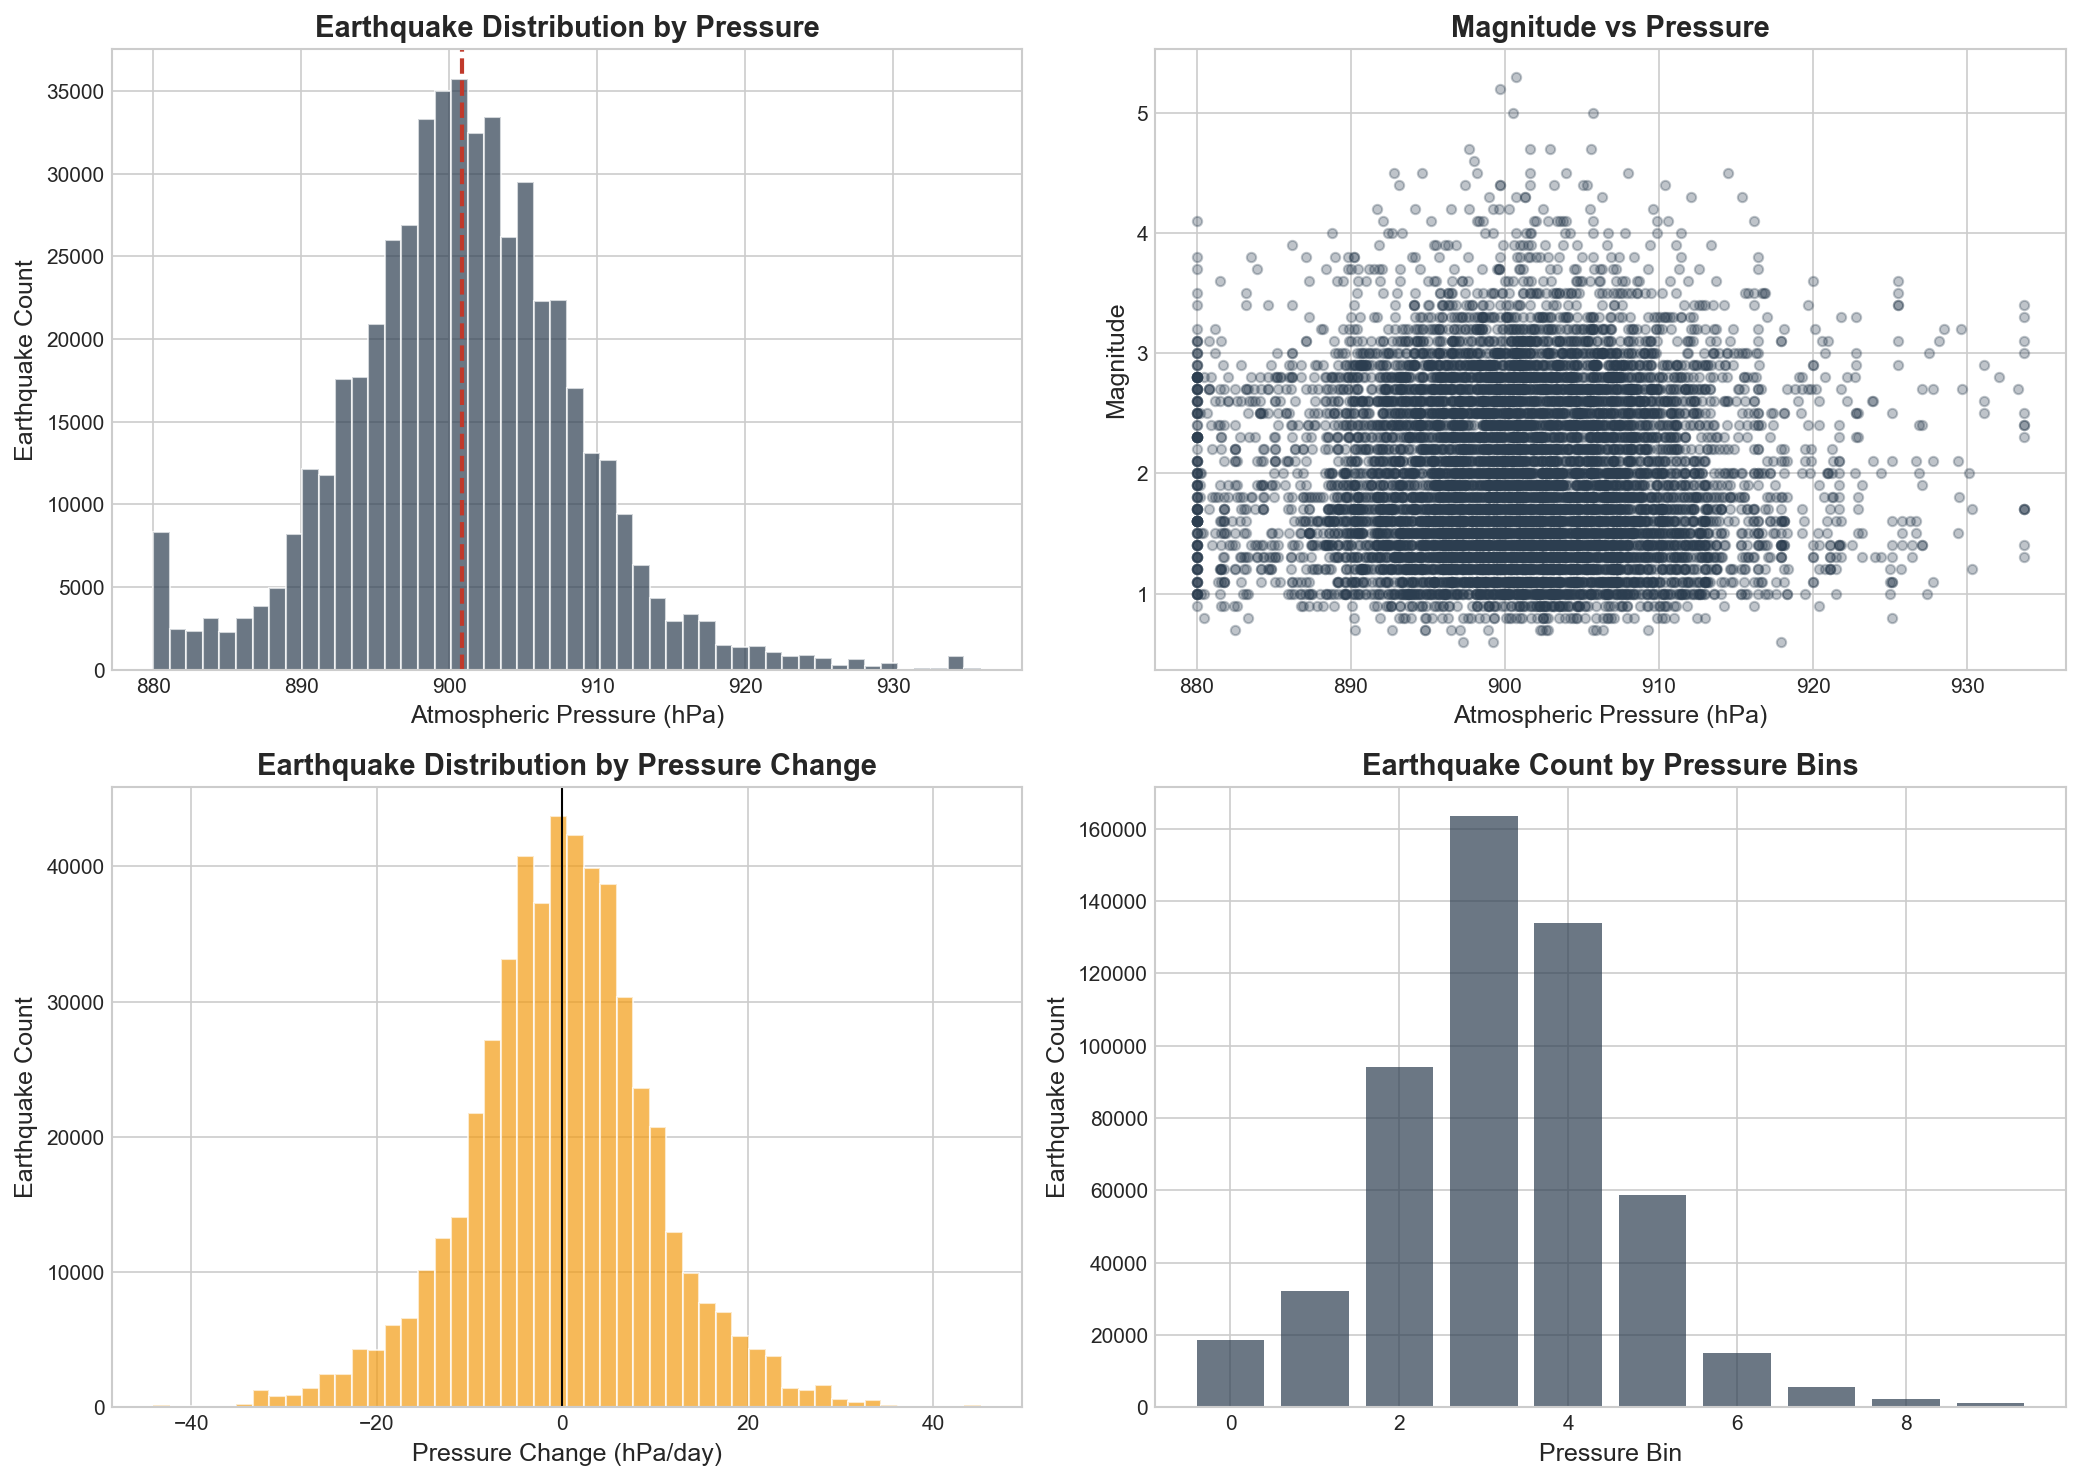

In [3]:
# Distribution plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Pressure distribution
ax1 = axes[0, 0]
ax1.hist(eq_pressure['pressure_hpa'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axvline(eq_pressure['pressure_hpa'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2)
ax1.set_xlabel('Atmospheric Pressure (hPa)')
ax1.set_ylabel('Earthquake Count')
ax1.set_title('Earthquake Distribution by Pressure', fontweight='bold')

# Pressure vs Magnitude
ax2 = axes[0, 1]
sample = eq_pressure.sample(min(10000, len(eq_pressure)))
ax2.scatter(sample['pressure_hpa'], sample['magnitude'], alpha=0.3, s=20, c=COLORS['primary'])
ax2.set_xlabel('Atmospheric Pressure (hPa)')
ax2.set_ylabel('Magnitude')
ax2.set_title('Magnitude vs Pressure', fontweight='bold')

# Pressure change distribution
if 'pressure_change' in eq_pressure.columns:
    ax3 = axes[1, 0]
    ax3.hist(eq_pressure['pressure_change'].dropna(), bins=50, color=COLORS['accent'], alpha=0.7, edgecolor='white')
    ax3.axvline(0, color='black', linestyle='-', linewidth=1)
    ax3.set_xlabel('Pressure Change (hPa/day)')
    ax3.set_ylabel('Earthquake Count')
    ax3.set_title('Earthquake Distribution by Pressure Change', fontweight='bold')

# Pressure bins
ax4 = axes[1, 1]
eq_pressure['pressure_bin'] = pd.cut(eq_pressure['pressure_hpa'], bins=10)
bin_counts = eq_pressure['pressure_bin'].value_counts().sort_index()
ax4.bar(range(len(bin_counts)), bin_counts.values, color=COLORS['primary'], alpha=0.7)
ax4.set_xlabel('Pressure Bin')
ax4.set_ylabel('Earthquake Count')
ax4.set_title('Earthquake Count by Pressure Bins', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'pressure_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [4]:
# Correlation analysis
r_mag, p_mag = stats.pearsonr(eq_pressure['pressure_hpa'], eq_pressure['magnitude'])
print(f"\nCorrelation (Pressure vs Magnitude):")
print(f"  r = {r_mag:.4f}, p-value = {p_mag:.4e}")

r_depth, p_depth = stats.pearsonr(eq_pressure['pressure_hpa'], eq_pressure['depth'])
print(f"\nCorrelation (Pressure vs Depth):")
print(f"  r = {r_depth:.4f}, p-value = {p_depth:.4e}")


Correlation (Pressure vs Magnitude):
  r = 0.0051, p-value = 1.9333e-04

Correlation (Pressure vs Depth):
  r = -0.0063, p-value = 4.9851e-06


In [5]:
# Compare earthquake vs non-earthquake days
# Group by date and count earthquakes
daily_counts = eq_pressure.groupby('date_only').agg({
    'eventID': 'count',
    'pressure_hpa': 'mean',
    'magnitude': 'max'
}).reset_index()
daily_counts.columns = ['date', 'eq_count', 'pressure', 'max_mag']

# High vs low earthquake days
median_count = daily_counts['eq_count'].median()
high_eq_days = daily_counts[daily_counts['eq_count'] > median_count]['pressure']
low_eq_days = daily_counts[daily_counts['eq_count'] <= median_count]['pressure']

t_stat, p_val = stats.ttest_ind(high_eq_days, low_eq_days)
print(f"\nT-test (Pressure on High vs Low Earthquake Days):")
print(f"  High EQ days mean pressure: {high_eq_days.mean():.1f} hPa")
print(f"  Low EQ days mean pressure: {low_eq_days.mean():.1f} hPa")
print(f"  t = {t_stat:.4f}, p-value = {p_val:.4f}")


T-test (Pressure on High vs Low Earthquake Days):
  High EQ days mean pressure: 900.7 hPa
  Low EQ days mean pressure: 900.7 hPa
  t = 0.3740, p-value = 0.7084


In [6]:
# Save results
results = pd.DataFrame({
    'Metric': ['Correlation (Pressure-Magnitude)', 'Correlation (Pressure-Depth)', 'T-test p-value'],
    'Value': [f"{r_mag:.4f}", f"{r_depth:.4f}", f"{p_val:.4f}"]
})
results.to_csv(os.path.join(TABLES_PATH, 'pressure_analysis.csv'), index=False)
print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'pressure_analysis.csv')}")


Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/pressure_analysis.csv
